BEGINNING OF PROGRAM

ASSESSING
ASSESSING COMPLETE


Perform cleanup, return dataframe with converted dtypes, no null values.
Suggest dropping these columns: 
 ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']
Dropped columns: 
 ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']
CLEANUP COMPLETE


Modify current_all_columns to reflect the removal of the previously stated columns from the dataframe
MODIFICATIONS COMPLETE
These are the symbols that will be dropped:  [['id', 'member_id', 'term', 'int_rate', 'grade', 'sub_grade', 'employment_length', 'verification_status', 'issue_date', 'payment_plan', 'purpose', 'dti', 'delinq_2yrs', 'home_ownership', 'earliest_credit_line', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'annual_inc']]
These are the remaining symbols

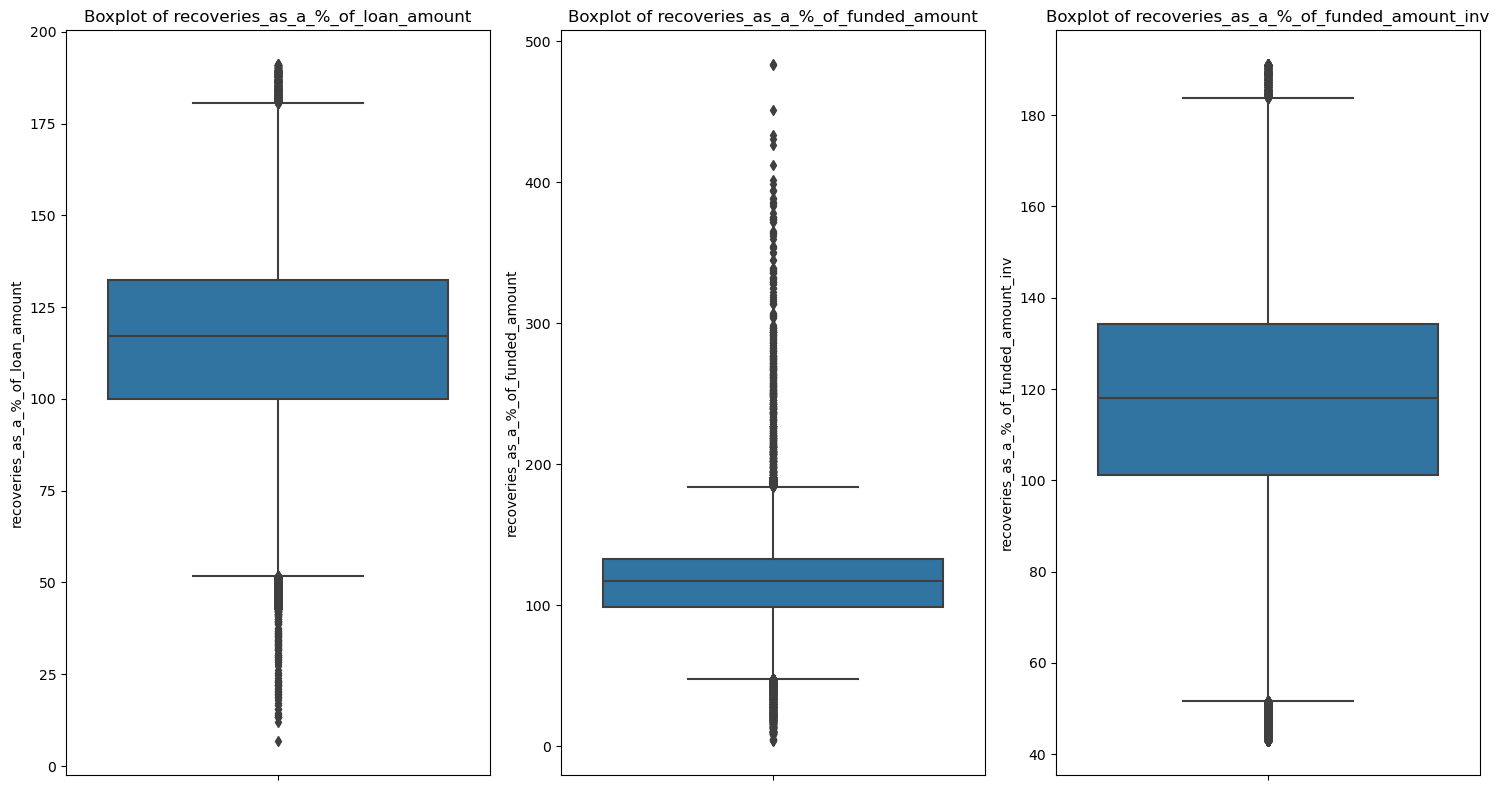

54158
Number of trimmed outliers: 4013
       recoveries_as_a_%_of_loan_amount_6months  \
0                                     62.345500   
1                                     61.501288   
2                                    128.967875   
3                                    133.230133   
4                                     59.890867   
...                                         ...   
54170                                127.098000   
54178                                142.356000   
54194                                103.789000   
54196                                142.381200   
54221                                131.308727   

       recoveries_as_a_%_of_funded_amount_6months  \
0                                       62.345500   
1                                       61.501288   
2                                      128.967875   
3                                      133.230133   
4                                       59.890867   
...                           

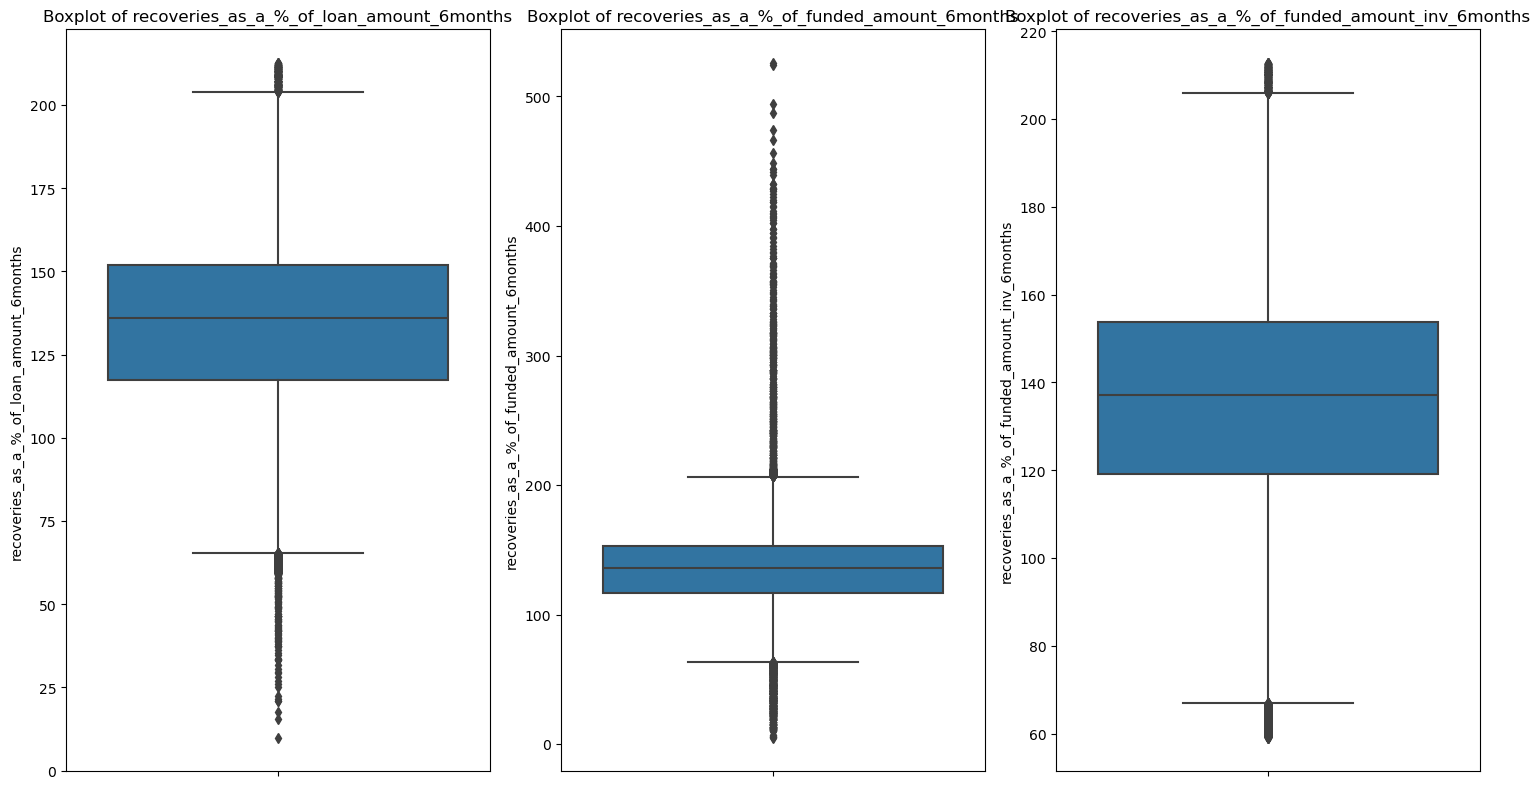

In [30]:
from RDSDatabaseConnector import RDSDatabaseConnector
from Plotter import Plotter
from DataTransform import DataTransform
from DataFrameTransform import DataFrameTransform
from DataFrameInfo import DataFrameInfo
from functions import display_suggested_drops, column_drop
import pandas as pd

from datetime import datetime

RDSD = RDSDatabaseConnector()
PL = Plotter()
DT = DataTransform()
DFT = DataFrameTransform()
DFI = DataFrameInfo()

print("BEGINNING OF PROGRAM\n")
print("ASSESSING")
datacsv_df = pd.read_csv('data.csv') #define dataframe
current_all_columns = list(datacsv_df.columns) #define list of all columns in dataframe

#columns to convert to the various formats:
list_of_to_categorical = ['term','grade','sub_grade', 'employment_length','home_ownership','verification_status','loan_status','payment_plan','purpose','delinq_2yrs','application_type']
list_of_to_boolean = ['policy_code']
list_of_to_float = []
list_of_to_int = []
date_columns = ['issue_date','earliest_credit_line','last_payment_date','next_payment_date','last_credit_pull_date']
acceptable_null_percentage: float = 80.0
print("ASSESSING COMPLETE")

def initial_general_cleanup(dataframe: pd.core.frame.DataFrame, acceptable_null_percentage):
    """Perform cleanup, return dataframe with converted dtypes, no null values.
    Specific cleanup processes to
    be listed here in detail:
    
    Perform Conversions - dates, categorical, boolean, float, int.
    Drop Null columns under X% full of rows.
    Impute columns with data.
    
    args:
    dataframe (type: pd.core.frame.DataFrame)
    acceptable_null_percentage (type: float)
    
    """
    #Column Conversions:
    dataframe = DT.convert_dates_to_proper_format(dataframe, date_columns, format = '%b-%Y') # %b is Jan/Feb/Mar etc
    dataframe = DT.to_categorical(dataframe, list_of_to_categorical)
    dataframe = DT.to_boolean(dataframe, list_of_to_boolean)
    dataframe = DT.to_float(dataframe, list_of_to_float)
    dataframe = DT.to_int(dataframe, list_of_to_int)
    
    #Drop Null columns under X%:
    acceptable_null_percentage = display_suggested_drops(dataframe, acceptable_null_percentage)
    dataframe, dropped_columns= column_drop(dataframe, acceptable_null_percentage)
    
    #Impute the rest of the columns:
    dataframe = DFT.impute(dataframe)
    
    return dataframe, dropped_columns

#Perform cleanup, return dataframe with converted dtypes, no null values.
print("\n")
print("Perform cleanup, return dataframe with converted dtypes, no null values.")
clean_dataframe, dropped_columns = initial_general_cleanup(datacsv_df, acceptable_null_percentage)
print("CLEANUP COMPLETE")

#remove dropped columns from current_all_columns variable.
print("\n")
print("Modify current_all_columns to reflect the removal of the previously stated columns from the dataframe")
for i in dropped_columns:
    current_all_columns.remove(i)
print("MODIFICATIONS COMPLETE")
### UP TO HERE YIELDS A DATAFRAME CALLED clean_dataframe.

###OPTIONAL CODE FOR SKEW CORRECTION BEGIN
'''#THE PART WHERE SKEW MAY BE IMPORTANT
#Check for skew in the dataframe
#Visualise skew in the dataframe
#Apply skew correction for each column if (on a per column basis) it is necessary
#PL.skew_correction(clean_dataframe)

#dataframe = apply_skew_correction(dataframe)
'''
###OPTIONAL CODE FOR SKEW CORRECTION END

def remove_columns_for_analysis(dataframe, columns):
    def remove_columns(dataframe, columns):
        clean_dataframe, symbols_removed = DT.excess_symbol_removal(dataframe, columns)
        return clean_dataframe, symbols_removed

    symbols_to_be_removed_from_dataframe = [columns]
    dataframe, symbols_removed = remove_columns(dataframe, symbols_to_be_removed_from_dataframe)
    for i in symbols_removed:
        dropped_columns.append(i)#append symbols to be removed to dropped_columns
    return dataframe

# Remove excess symbols
symbols = ['id', 'member_id', 'term', 'int_rate', 'grade', 'sub_grade', 'employment_length',
           'verification_status', 'issue_date', 'payment_plan', 'purpose', 'dti', 'delinq_2yrs', 'home_ownership',
           'earliest_credit_line', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'last_payment_date',
           'last_credit_pull_date', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'annual_inc']

dataframe_for_MS4_T1_analysis = remove_columns_for_analysis(clean_dataframe, symbols)
### UP TO HERE YIELDS A DATAFRAME CALLED dataframe_for_MS4_T1_analysis.
print("\n")

"""Milestone 4 Task 1 Step 1
    Step 1: Summarise currently what percentage of the loans are recovered against the investor 
            funding and the total amount funded. Visualise your results on an appropriate graph.
"""
###Milestone 4 Task 1 Step 1
#triple-quote string containing functions: create_recoveries_df, remove_rows_of_zeros
def create_recoveries_df(dataframe):
    """Create a dataframe from pandas series.

    Args:
        dataframe (_type_): _description_
    """
    def recoveries_divided_by(dataframe):
        """Create pandas series from dataframe.

        Args:
            dataframe (_type_): _description_

        Returns:
            _type_: _description_
        """
        recoveries_as_a_percentage_of_loan_amount: pd.Series = (((dataframe['total_payment']+dataframe['total_rec_int'])/dataframe['loan_amount'])*100)
        recoveries_as_a_percentage_of_funded_amount: pd.Series = (((dataframe['total_payment']+dataframe['total_rec_int'])/dataframe['funded_amount'])*100)
        recoveries_as_a_percentage_of_funded_amount_inv: pd.Series = (((dataframe['total_payment']+dataframe['total_rec_int'])/dataframe['funded_amount_inv'])*100)
        return recoveries_as_a_percentage_of_loan_amount, recoveries_as_a_percentage_of_funded_amount, recoveries_as_a_percentage_of_funded_amount_inv
    a, b, c = recoveries_divided_by(dataframe)
    dataframe = pd.DataFrame({'recoveries_as_a_%_of_loan_amount':a, 'recoveries_as_a_%_of_funded_amount':b, 'recoveries_as_a_%_of_funded_amount_inv':c})
    return dataframe

def create_recoveries_df_6months(dataframe):
    """Create a dataframe from pandas series.

    Args:
        dataframe (_type_): _description_
    """
    def recoveries_divided_by_6months(dataframe):
        """Create pandas series from dataframe.

        Args:
            dataframe (_type_): _description_

        Returns:
            _type_: _description_
        """
        recoveries_as_a_percentage_of_loan_amount_6months = ((((dataframe['instalment'] * 6)+dataframe['total_payment']+dataframe['total_rec_int'])/dataframe['loan_amount'])*100)
        recoveries_as_a_percentage_of_funded_amount_6months = ((((dataframe['instalment'] * 6)+dataframe['total_payment']+dataframe['total_rec_int'])/dataframe['funded_amount'])*100)
        recoveries_as_a_percentage_of_funded_amount_inv_6months = ((((dataframe['instalment'] * 6)+dataframe['total_payment']+dataframe['total_rec_int'])/dataframe['funded_amount_inv'])*100)
        return recoveries_as_a_percentage_of_loan_amount_6months, recoveries_as_a_percentage_of_funded_amount_6months, recoveries_as_a_percentage_of_funded_amount_inv_6months
    d, e, f = recoveries_divided_by_6months(dataframe)
    dataframe = pd.DataFrame({'recoveries_as_a_%_of_loan_amount_6months':d, 'recoveries_as_a_%_of_funded_amount_6months':e, 'recoveries_as_a_%_of_funded_amount_inv_6months':f})
    return dataframe

def remove_rows_of_zeros(dataframe):
    """Remove rows where there are zeros, return recoveries.

    Args:
        dataframe (_type_): _description_

    Returns:
        _type_: _description_
    """
    dataframe = dataframe[(dataframe != 0).any(axis=1)]#remove rows where nothing is there on any of the columns
    print(len(dataframe))
    return dataframe

recoveries_df = create_recoveries_df(dataframe_for_MS4_T1_analysis)
recoveries_df = remove_rows_of_zeros(recoveries_df) #issue here
recoveries_trimmed_df = DFT.trim_by_iqr_limits(recoveries_df, list(recoveries_df.columns))
#trim by iqr works, zscore yields empty dataframe.
#Too many are trimmed perhaps?
print(recoveries_trimmed_df)
PL.plot_boxplots(recoveries_trimmed_df, ['recoveries_as_a_%_of_loan_amount', 'recoveries_as_a_%_of_funded_amount', 'recoveries_as_a_%_of_funded_amount_inv'])

### Milestone 4 Task 1 Step 2
recoveries_df_6months = create_recoveries_df_6months(dataframe_for_MS4_T1_analysis)
recoveries_df_6months = remove_rows_of_zeros(recoveries_df_6months)
recoveries_trimmed_df_6months = DFT.trim_by_iqr_limits(recoveries_df_6months, list(recoveries_df_6months.columns))
print(recoveries_trimmed_df_6months)
PL.plot_boxplots(recoveries_trimmed_df_6months, ['recoveries_as_a_%_of_loan_amount_6months', 'recoveries_as_a_%_of_funded_amount_6months', 'recoveries_as_a_%_of_funded_amount_inv_6months'])
